# Baseline model based on anatomy features

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train, labels_train = get_train_data(path=path)
data_test, labels_test = get_test_data(path=path)

In [4]:
data_train['participants_sex'] = data_train['participants_sex'].map({'F': -1.0, 'M': +1.0}) 

In [5]:
data_train.shape, data_test.shape

((1127, 220), (23, 220))

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [9]:
anatomy_cols = [col for col in data_train1.columns if col.startswith('anatomy')]
anatomy_cols.remove('anatomy_select')
null_anatomy_cols = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities'
]

for c in null_anatomy_cols:
    anatomy_cols.remove(c)

participant_cols = [col for col in data_train1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [ ]:
inverted_cols = []

for c in anatomy_cols + ["participants_age", ]:
    data_train1.loc[:, "1/{}".format(c)] = 1.0 / (data_train1[c] + 1e-7)
    inverted_cols.append("1/{}".format(c))

### Basic logistic regression 

In [20]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df[anatomy_cols + participant_cols]
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(PolynomialFeatures(2),
                                 StandardScaler(), 
                                 LogisticRegression())

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [21]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.626 +- 0.014 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.594 +- 0.014


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.0min finished


```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.637 +- 0.014 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.604 +- 0.014
```

Let's visualize feature importance:

In [30]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [23]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [24]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

In [27]:
poly_feature = pipe.named_steps['classifier'].clf.named_steps['polynomialfeatures']
cols = anatomy_cols + participant_cols + inverted_cols

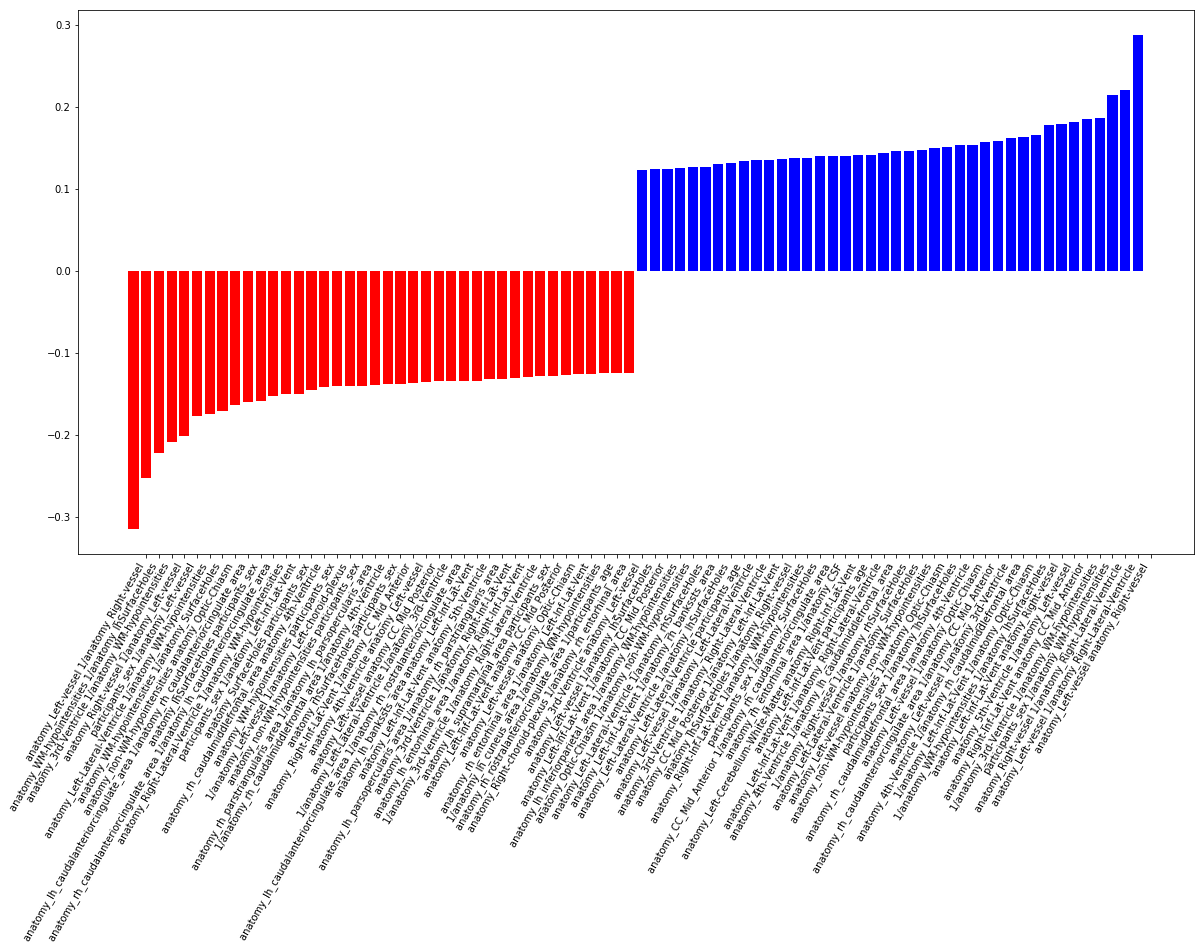

In [46]:
visualize_coefficients(log_reg, feature_names=poly_feature.get_feature_names(input_features=cols), n_top_features=40)

In [32]:
# coef = log_reg.coef_.ravel()
# poly_cols = poly_feature.get_feature_names(input_features=cols)
# np.savez_compressed("log_reg_coef_f_f2_1f_anatomy_participant_test_size=05.npz", coef=coef, poly_cols=poly_cols)

In [7]:
# log_reg_coef_2xfeatures = np.load("log_reg_coef_2xfeatures.npz")
# coef = log_reg_coef_2xfeatures['coef']
# poly_cols = log_reg_coef_2xfeatures['poly_cols']

In [53]:
coef = log_reg.coef_.ravel()
positive_coefficients_ = np.argsort(coef)
negative_coefficients_ = np.argsort(coef)

In [68]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.31531439861437294, 0.28770429347592985, 0.0)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


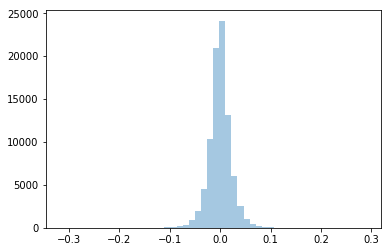

In [71]:
sns.distplot(coef, kde=False)

In [77]:
t = 0.06
len(coef[(coef > t) | (coef < -t)]), len(coef[(coef > t)])

(1617, 787)

In [54]:
n_top_features = 1000

positive_coefficients = positive_coefficients_[-n_top_features:]
negative_coefficients = negative_coefficients_[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()

In [48]:
len(topk_2xfeature_names)

2000

In [49]:
topk_feature_names = ["anatomy_MaskVol", "anatomy_rhCerebralWhiteMatterVol", "anatomy_rh_MeanThickness_thickness", "anatomy_Brain-Stem", "anatomy_lh_MeanThickness_thickness", "anatomy_lh_precentral_area", "anatomy_rh_lateralorbitofrontal_thickness", "anatomy_lh_superiortemporal_area", "anatomy_rh_middletemporal_thickness", "anatomy_Right-Cerebellum-White-Matter", "anatomy_rh_insula_thickness", "anatomy_lh_rostralmiddlefrontal_area", "anatomy_rh_pericalcarine_area", "anatomy_BrainSegVol", "anatomy_lh_entorhinal_area", "anatomy_BrainSegVolNotVent", "anatomy_lh_superiorparietal_area", "anatomy_lh_pericalcarine_area", "anatomy_rh_middletemporal_area", "anatomy_SupraTentorialVolNotVentVox", "anatomy_lhCortexVol", "anatomy_lh_lateralorbitofrontal_area", "anatomy_rh_medialorbitofrontal_area", "anatomy_rhSurfaceHoles", "anatomy_rh_inferiorparietal_area", "anatomy_rh_fusiform_area", "anatomy_CC_Posterior", "anatomy_rh_temporalpole_area", "anatomy_Right-Amygdala", "anatomy_Left-Thalamus-Proper", "anatomy_lh_frontalpole_area", "anatomy_lh_entorhinal_thickness", "anatomy_rh_insula_area", "anatomy_lh_caudalanteriorcingulate_area", "anatomy_lh_lateralorbitofrontal_thickness", "anatomy_Right-Accumbens-area", "anatomy_lh_precuneus_thickness", "anatomy_Left-Putamen", "anatomy_rh_caudalmiddlefrontal_thickness", "anatomy_CC_Central", "anatomy_Left-Caudate", "anatomy_rh_postcentral_thickness", "anatomy_lh_insula_thickness", "participants_sex", "anatomy_rh_entorhinal_thickness", "anatomy_Left-Inf-Lat-Vent", "anatomy_rh_precentral_area", "participants_age", "anatomy_rh_frontalpole_area", "anatomy_Right-Pallidum", "anatomy_rh_rostralmiddlefrontal_area", "anatomy_rh_superiortemporal_thickness", "anatomy_Left-Hippocampus", "anatomy_WM-hypointensities", "anatomy_lh_insula_area", "anatomy_eTIV", "anatomy_EstimatedTotalIntraCranialVol", "anatomy_lh_medialorbitofrontal_thickness", "anatomy_rh_rostralmiddlefrontal_thickness", "anatomy_rh_bankssts_area", "anatomy_rh_precuneus_area", "anatomy_Left-Amygdala", "anatomy_lhSurfaceHoles", "anatomy_lh_lingual_area", "anatomy_rhCortexVol", "anatomy_rh_lateraloccipital_thickness", "anatomy_Right-Cerebellum-Cortex", "anatomy_rh_parsorbitalis_thickness", "anatomy_lh_cuneus_thickness", "anatomy_lh_parsorbitalis_area", "anatomy_rh_lateraloccipital_area", "anatomy_lh_fusiform_thickness", "anatomy_rh_superiorfrontal_area", "anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle", "anatomy_Left-VentralDC", "anatomy_lh_superiortemporal_thickness", "anatomy_rh_inferiortemporal_area", "anatomy_BrainSegVol-to-eTIV", "anatomy_lhCerebralWhiteMatterVol", "anatomy_rh_precuneus_thickness", "anatomy_lh_superiorfrontal_thickness", "anatomy_MaskVol-to-eTIV", ]

len(topk_feature_names)

84

### Basic logistic regression on poly features

In [50]:
X_df = data_train
for fname in topk_2xfeature_names:
    if " " in fname:
        X_df.loc[:, fname] = 0.0
        f1, f2 = fname.split(" ")
        X_df.loc[:, fname] = X_df[f1] * X_df[f2]

In [51]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        # create polynomial features:
#         if X_df['participants_sex'].unique().dtype != int:
#             X_df['participants_sex'] = X_df['participants_sex'].map({'F': 0, 'M': 1}) 
#         for fname in topk_2xfeature_names:
#             if " " in fname:
#                 X_df.loc[:, fname] = 0.0
#                 f1, f2 = fname.split(" ")
#                 X_df.loc[:, fname] = X_df[f1] * X_df[f2]
        return X_df[topk_2xfeature_names + topk_feature_names]
    
    
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 100
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [52]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.760 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.694 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.1s finished


Find optimal number of features

In [104]:
n_top_features = 1000
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()


X_df = data_train
for fname in topk_2xfeature_names:
    if " " in fname:
        X_df.loc[:, fname] = 0.0
        f1, f2 = fname.split(" ")
        X_df.loc[:, fname] = X_df[f1] * X_df[f2]

In [102]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [113]:
positive_coefficients = np.argsort(coef)
negative_coefficients = np.argsort(coef)


class _FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
    
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        return X_df[self.features]

    
def _evaluation(X, y, features):
    pipe = make_pipeline(_FeatureExtractor(features), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


def score(params):
    num_features = params['num_features']
    
    print("Trial: num_features: {}".format(num_features), end=" -> ")
    
    n_top_features = num_features
    positive_coefficients_ = positive_coefficients[-n_top_features:]
    negative_coefficients_ = negative_coefficients[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients_, positive_coefficients_])
    topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()
        
    results = _evaluation(data_train, labels_train, topk_2xfeature_names + topk_feature_names)
    roc = np.mean(results['test_roc_auc']) 
    acc = np.mean(results['test_accuracy'])
    res = roc + acc
    print("Score: roc = {} | acc = {}".format(roc, acc))
    return {'loss': 2.0 - res, 'status': STATUS_OK}
    
    
def get_num_features():
    return hp.randint('num_features', 750) + 150
    
    
def optimize(trials, max_evals):
    params = {'num_features': get_num_features()}
    best = fmin(score, params, algo=tpe.suggest, trials=trials, max_evals=max_evals)    
    return best


trials = Trials()
best_num_features = optimize(trials, max_evals=50)
best_num_features

Trial: num_features: 644 -> Score: roc = 0.7835549114737572 | acc = 0.7120567375886525
Trial: num_features: 186 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


Score: roc = 0.7466561653329973 | acc = 0.6828014184397164
Trial: num_features: 605 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished


Score: roc = 0.783729443639342 | acc = 0.7148936170212765
Trial: num_features: 350 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7749593598386995 | acc = 0.7070921985815602
Trial: num_features: 408 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.7s finished


Score: roc = 0.7816583706130679 | acc = 0.7122340425531914
Trial: num_features: 629 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


Score: roc = 0.7852416356877324 | acc = 0.7152482269503546
Trial: num_features: 395 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Score: roc = 0.7802665238485287 | acc = 0.7101063829787234
Trial: num_features: 711 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.3s finished


Score: roc = 0.7889150022052801 | acc = 0.7145390070921986
Trial: num_features: 547 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7863039506017264 | acc = 0.7157801418439717
Trial: num_features: 773 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Score: roc = 0.7863726293239243 | acc = 0.7145390070921985
Trial: num_features: 769 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7836330413962573 | acc = 0.7115248226950355
Trial: num_features: 232 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.6s finished


Score: roc = 0.756112406275597 | acc = 0.6920212765957447
Trial: num_features: 875 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


Score: roc = 0.7857601915443262 | acc = 0.7143617021276596
Trial: num_features: 606 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.3s finished


Score: roc = 0.7834131434692206 | acc = 0.7148936170212767
Trial: num_features: 425 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Score: roc = 0.7814063386050029 | acc = 0.7088652482269503
Trial: num_features: 452 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7843992187007749 | acc = 0.7111702127659574
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 846 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7872345787915066 | acc = 0.7161347517730496
Trial: num_features: 520 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.9s finished


Score: roc = 0.7847848276731144 | acc = 0.7152482269503546
Trial: num_features: 228 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Score: roc = 0.7537981223615399 | acc = 0.6906028368794326
Trial: num_features: 156 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished


Score: roc = 0.7433148509860753 | acc = 0.677836879432624
Trial: num_features: 518 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.0s finished


Score: roc = 0.7827988154495621 | acc = 0.7118794326241135
Trial: num_features: 807 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.6s finished


Score: roc = 0.7866523848528764 | acc = 0.7131205673758865
Trial: num_features: 437 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Score: roc = 0.7837149517988784 | acc = 0.7118794326241135
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 585 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7851490139247685 | acc = 0.7115248226950355
Trial: num_features: 550 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


Score: roc = 0.7841963329342827 | acc = 0.7127659574468085
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 310 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.7663656984437023 | acc = 0.6957446808510637
Trial: num_features: 166 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.5s finished


Score: roc = 0.7435486106735555 | acc = 0.6764184397163121
Trial: num_features: 284 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished


Score: roc = 0.7614932896477853 | acc = 0.6904255319148935
Trial: num_features: 276 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished


Score: roc = 0.7601335769642745 | acc = 0.6890070921985816
Trial: num_features: 612 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.5s finished


Score: roc = 0.7843254993384161 | acc = 0.7177304964539009
Trial: num_features: 341 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Score: roc = 0.7740690567702098 | acc = 0.7053191489361701
Trial: num_features: 488 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


Score: roc = 0.7838806628441812 | acc = 0.7086879432624114
Trial: num_features: 169 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.1s finished


Score: roc = 0.7455050091361604 | acc = 0.6810283687943264
Trial: num_features: 762 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished


Score: roc = 0.7849310062377922 | acc = 0.7120567375886525
Trial: num_features: 619 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.7s finished


Score: roc = 0.7841578980530527 | acc = 0.7157801418439715
Trial: num_features: 255 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Score: roc = 0.7568615714195703 | acc = 0.6895390070921985
Trial: num_features: 562 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.0s finished


Score: roc = 0.7833129607460148 | acc = 0.7140070921985815
Trial: num_features: 254 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished


Score: roc = 0.7578741100119715 | acc = 0.6907801418439716
Trial: num_features: 743 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7872465503118896 | acc = 0.7129432624113475
Trial: num_features: 833 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7880788860185244 | acc = 0.7148936170212765
Trial: num_features: 515 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Score: roc = 0.7839984878079516 | acc = 0.7134751773049646
Trial: num_features: 181 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.0s finished


Score: roc = 0.7469371810219898 | acc = 0.6833333333333333
Trial: num_features: 688 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.4s finished


Score: roc = 0.7851773675256758 | acc = 0.7122340425531914
Trial: num_features: 806 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7854640539348497 | acc = 0.7122340425531914
Trial: num_features: 836 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.4s finished


Score: roc = 0.788337218826791 | acc = 0.7152482269503546
Trial: num_features: 831 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Score: roc = 0.7863820805242265 | acc = 0.7129432624113475
Trial: num_features: 194 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Score: roc = 0.7443670846197467 | acc = 0.6799645390070922
Trial: num_features: 332 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


Score: roc = 0.7705380883372188 | acc = 0.700354609929078
Trial: num_features: 266 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


Score: roc = 0.7579194757734232 | acc = 0.6879432624113474
Trial: num_features: 285 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.2s finished


Score: roc = 0.7622348938315165 | acc = 0.6907801418439716
Trial: num_features: 614 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished


Score: roc = 0.7825215802406906 | acc = 0.7154255319148938
Trial: num_features: 552 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


Score: roc = 0.7835870455547854 | acc = 0.7161347517730496
Trial: num_features: 380 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7773895784764665 | acc = 0.7074468085106382
Trial: num_features: 357 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Score: roc = 0.776736815575578 | acc = 0.7079787234042553
Trial: num_features: 324 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Score: roc = 0.7660695608342261 | acc = 0.6943262411347517
Trial: num_features: 618 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


Score: roc = 0.7836702161174469 | acc = 0.7143617021276596
Trial: num_features: 473 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.7s finished


Score: roc = 0.7835271879528699 | acc = 0.7085106382978723
Trial: num_features: 892 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


Score: roc = 0.7858276101064835 | acc = 0.7148936170212766
Trial: num_features: 653 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.9s finished


Score: roc = 0.7832373511435952 | acc = 0.7127659574468086
Trial: num_features: 236 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Score: roc = 0.7587335391594733 | acc = 0.6891843971631205
Trial: num_features: 379 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.9s finished


Score: roc = 0.7787203074790499 | acc = 0.7069148936170213
Trial: num_features: 202 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.8s finished


Score: roc = 0.746930250141768 | acc = 0.6849290780141845
Trial: num_features: 531 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7858042971457374 | acc = 0.7166666666666667
Trial: num_features: 519 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.4s finished


Score: roc = 0.78453531598513 | acc = 0.7129432624113475
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 208 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7457375086636002 | acc = 0.6822695035460994
Trial: num_features: 459 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7801631907252221 | acc = 0.7058510638297872
Trial: num_features: 334 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Score: roc = 0.7728863965723647 | acc = 0.701063829787234
Trial: num_features: 702 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.8s finished


Score: roc = 0.787430533677777 | acc = 0.7099290780141843
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 720 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7868388885388444 | acc = 0.7134751773049646
Trial: num_features: 237 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.757903093692899 | acc = 0.6895390070921985
Trial: num_features: 590 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished


Score: roc = 0.785972528511121 | acc = 0.7131205673758865
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 649 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Score: roc = 0.7849184046373889 | acc = 0.7159574468085107
Trial: num_features: 314 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.9s finished


Score: roc = 0.7655062692962006 | acc = 0.6946808510638297
Trial: num_features: 462 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7841786906937182 | acc = 0.7085106382978723
Trial: num_features: 187 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7465314094890051 | acc = 0.6836879432624114
Trial: num_features: 751 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


Score: roc = 0.7886314661962068 | acc = 0.7148936170212766
Trial: num_features: 463 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.7827383277676265 | acc = 0.7076241134751773
Trial: num_features: 512 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.7s finished


Score: roc = 0.7848598071955137 | acc = 0.7111702127659574
Trial: num_features: 779 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished


Score: roc = 0.7853386680108373 | acc = 0.7120567375886526
Trial: num_features: 626 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7845201940646462 | acc = 0.7127659574468086
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 791 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7879478293743305 | acc = 0.7148936170212765
Trial: num_features: 450 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7851565748850104 | acc = 0.7093971631205673
Trial: num_features: 436 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7824547917585533 | acc = 0.7081560283687943
Trial: num_features: 886 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7862346417995085 | acc = 0.7148936170212765
Trial: num_features: 203 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished


Score: roc = 0.7449404574380947 | acc = 0.6826241134751774
Trial: num_features: 877 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7847022871904732 | acc = 0.7138297872340427
Trial: num_features: 885 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.3s finished


Score: roc = 0.785566126898116 | acc = 0.7163120567375887
Trial: num_features: 542 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.0s finished


Score: roc = 0.784821372314284 | acc = 0.7143617021276596
Trial: num_features: 339 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.7735983869951484 | acc = 0.7037234042553191
Trial: num_features: 712 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.2s finished


Score: roc = 0.7882288450633231 | acc = 0.7147163120567376
Trial: num_features: 692 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.0s finished


Score: roc = 0.7851408228845063 | acc = 0.7113475177304964
Trial: num_features: 598 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7869913679037237 | acc = 0.7140070921985815
Trial: num_features: 220 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished


Score: roc = 0.7537464557998866 | acc = 0.6893617021276596
Trial: num_features: 329 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished


Score: roc = 0.7711108310755466 | acc = 0.699822695035461
Trial: num_features: 464 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished


Score: roc = 0.7823533488753072 | acc = 0.7069148936170213
Trial: num_features: 584 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Score: roc = 0.7840407031693024 | acc = 0.7092198581560283
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 747 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.787430533677777 | acc = 0.7152482269503546
Trial: num_features: 631 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.8s finished


Score: roc = 0.7849820427194254 | acc = 0.7170212765957447
Trial: num_features: 219 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


Score: roc = 0.7536721063575074 | acc = 0.6900709219858155
Trial: num_features: 509 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Score: roc = 0.7845573687858358 | acc = 0.7122340425531914
Trial: num_features: 407 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished


Score: roc = 0.7816508096528259 | acc = 0.7093971631205673
Trial: num_features: 274 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7618335328586731 | acc = 0.6920212765957446
Trial: num_features: 355 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7757891752252537 | acc = 0.7083333333333334
Trial: num_features: 532 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished


Score: roc = 0.7839310692457943 | acc = 0.7145390070921985
Trial: num_features: 788 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


Score: roc = 0.7870770587864659 | acc = 0.7156028368794326
Trial: num_features: 182 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished


Score: roc = 0.747387058156386 | acc = 0.6835106382978724
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 850 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Score: roc = 0.787089030306849 | acc = 0.7140070921985816
Trial: num_features: 715 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Score: roc = 0.7852554974481759 | acc = 0.7108156028368795
Trial: num_features: 857 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7856625291412009 | acc = 0.7131205673758865
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.7s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 205 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Score: roc = 0.7443362106987588 | acc = 0.6847517730496454
Trial: num_features: 215 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7495854073467331 | acc = 0.6820921985815602
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 198 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7468388885388444 | acc = 0.6819148936170214
Trial: num_features: 322 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7677191103270115 | acc = 0.6969858156028368
Trial: num_features: 789 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7867059416545902 | acc = 0.7136524822695035
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.3s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 817 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.0s finished


Score: roc = 0.789012034528385 | acc = 0.7166666666666667
Trial: num_features: 811 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Score: roc = 0.7886932140381828 | acc = 0.7157801418439715
Trial: num_features: 646 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7852542372881356 | acc = 0.7141843971631205
Trial: num_features: 822 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Score: roc = 0.7893610988595553 | acc = 0.7173758865248226
Trial: num_features: 693 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7855598260979144 | acc = 0.7115248226950354
Trial: num_features: 778 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.2s finished


Score: roc = 0.7868262869384411 | acc = 0.7140070921985816
Trial: num_features: 430 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


Score: roc = 0.7810087581122803 | acc = 0.7062056737588652
Trial: num_features: 554 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7826463360846827 | acc = 0.7125886524822694
Trial: num_features: 630 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Score: roc = 0.7848932014365825 | acc = 0.7150709219858157
Trial: num_features: 157 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.9s finished


Score: roc = 0.7431989162623653 | acc = 0.6787234042553192
Trial: num_features: 841 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


Score: roc = 0.7876088463234832 | acc = 0.7159574468085107
Trial: num_features: 438 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished


Score: roc = 0.7824560519185937 | acc = 0.7115248226950355
Trial: num_features: 569 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7849511687984373 | acc = 0.7141843971631204
Trial: num_features: 837 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.787786528889169 | acc = 0.7156028368794326
Trial: num_features: 469 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.3s finished


Score: roc = 0.7816596307731082 | acc = 0.7058510638297872
Trial: num_features: 855 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Score: roc = 0.78542624913364 | acc = 0.7138297872340426
Trial: num_features: 707 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.7s finished


Score: roc = 0.7872667128725348 | acc = 0.7113475177304964
Trial: num_features: 824 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.7861508411568269 | acc = 0.7156028368794327
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 587 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


Score: roc = 0.7828826160922436 | acc = 0.7092198581560283
Trial: num_features: 523 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7844288324617226 | acc = 0.7124113475177305
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 822 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7893610988595553 | acc = 0.7173758865248226
Trial: num_features: 262 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Score: roc = 0.7574210824774746 | acc = 0.6911347517730496
Trial: num_features: 832 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.7s finished


Score: roc = 0.7878892319324555 | acc = 0.7145390070921986
Trial: num_features: 361 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Score: roc = 0.7768495998991872 | acc = 0.7090425531914893
Trial: num_features: 575 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.4s finished


Score: roc = 0.7856795413017454 | acc = 0.7150709219858156
Trial: num_features: 400 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Score: roc = 0.7799426627181651 | acc = 0.7113475177304964
Trial: num_features: 257 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.5s finished


Score: roc = 0.7585917711549367 | acc = 0.6895390070921985
Trial: num_features: 858 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.0s finished


Score: roc = 0.7861905361980972 | acc = 0.7129432624113475
Trial: num_features: 382 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.5s finished


Score: roc = 0.7787505513200177 | acc = 0.7069148936170213
Trial: num_features: 678 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.2s finished


Score: roc = 0.7838315166026085 | acc = 0.7117021276595745
Trial: num_features: 229 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.7s finished


Score: roc = 0.7536481633167413 | acc = 0.6902482269503546
Trial: num_features: 887 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.9s finished


Score: roc = 0.7859429147501733 | acc = 0.7173758865248228
Trial: num_features: 216 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.3s finished
Process ForkPoolWorker-13913:
Process ForkPoolWorker-13914:
Traceback (most recent call last):
Process ForkPoolWorker-13912:
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [119]:
best_num_features = 822

n_top_features = best_num_features
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()
print(len(topk_2xfeature_names))

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        return X_df[topk_2xfeature_names + topk_feature_names]


results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

1644
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.789 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.717 +- 0.017


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.0s finished


## Test size = 0.5

### Anatomy + Participant

715
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.711 +- 0.018
```


700
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.788 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.711 +- 0.015
```

650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.710 +- 0.017
```


625
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.784 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.714 +- 0.017
```


600
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.787 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.718 +- 0.017
```


575
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.786 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.715 +- 0.015
```


550
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.784 +- 0.012 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.713 +- 0.010
```

500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.013 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.712 +- 0.017
```

450
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.709 +- 0.020
```


250
```
Training score ROC-AUC: 0.998 +- 0.005
Validation score ROC-AUC: 0.756 +- 0.014 

Training score accuracy: 0.994 +- 0.019
Validation score accuracy: 0.691 +- 0.019
```



120
```
Training score ROC-AUC: 0.989 +- 0.020
Validation score ROC-AUC: 0.739 +- 0.019 

Training score accuracy: 0.969 +- 0.046
Validation score accuracy: 0.677 +- 0.017
```

## Test size = 0.2

#### Anatomy + Participant

715
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.899 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.812 +- 0.021
```


700
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.899 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.021
```

695
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.896 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.811 +- 0.022
```


675
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.895 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.020
```


650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.892 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.821 +- 0.020
```


625
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.891 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.021
```


500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.884 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.819 +- 0.020
```


150
```
Training score ROC-AUC: 0.982 +- 0.015
Validation score ROC-AUC: 0.797 +- 0.014 

Training score accuracy: 0.935 +- 0.032
Validation score accuracy: 0.712 +- 0.022
```


#### Anatomy only

650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.892 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.822 +- 0.022
```


600
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.889 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.810 +- 0.029
```


500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.886 +- 0.020 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.802 +- 0.020
```


400
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.876 +- 0.020 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.799 +- 0.024
```


300
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.853 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.769 +- 0.023
```


100
```
Training score ROC-AUC: 0.945 +- 0.014
Validation score ROC-AUC: 0.754 +- 0.019 

Training score accuracy: 0.873 +- 0.016
Validation score accuracy: 0.685 +- 0.023
```


baseline 1x features:
```
Training score ROC-AUC: 0.819 +- 0.004
Validation score ROC-AUC: 0.741 +- 0.018 

Training score accuracy: 0.744 +- 0.008
Validation score accuracy: 0.676 +- 0.018
```

In [66]:
len(topk_feature_names), len(topk_2xfeature_names)

(82, 1300)

Check coeff importance:

In [67]:
pipe = make_pipeline(FeatureExtractor(), Classifier())

In [68]:
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [69]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

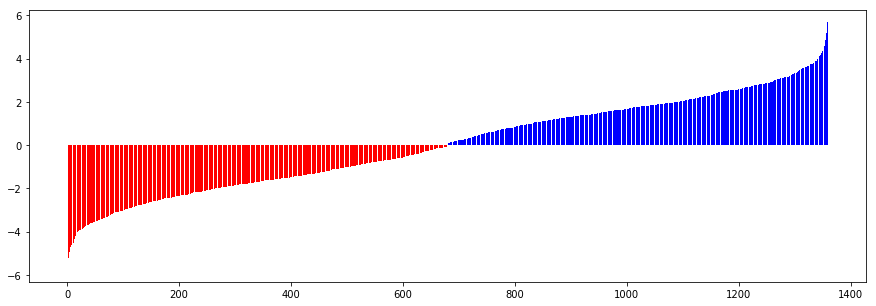

In [84]:
visualize_coefficients(log_reg, feature_names=None, n_top_features=680)

In [123]:
len(topk_2xfeature_names)

1644

In [124]:
print("[", end="")
for f in topk_2xfeature_names:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Right-Inf-Lat-Vent anatomy_CC_Mid_Posterior", "anatomy_non-WM-hypointensities anatomy_Optic-Chiasm", "anatomy_Left-vessel anatomy_CC_Mid_Posterior", "anatomy_Left-Inf-Lat-Vent anatomy_CC_Mid_Posterior", "anatomy_rh_bankssts_area anatomy_Left-Inf-Lat-Vent", "anatomy_rh_pericalcarine_area anatomy_Left-Accumbens-area", "anatomy_WM-hypointensities participants_sex", "anatomy_lh_temporalpole_thickness anatomy_Optic-Chiasm", "anatomy_lh_pericalcarine_area anatomy_Right-Inf-Lat-Vent", "anatomy_lh_caudalmiddlefrontal_area anatomy_4th-Ventricle", "anatomy_rh_caudalmiddlefrontal_area anatomy_4th-Ventricle", "anatomy_lh_pericalcarine_area anatomy_Left-Accumbens-area", "anatomy_Left-choroid-plexus anatomy_Right-Accumbens-area", "anatomy_rh_entorhinal_area anatomy_CSF", "anatomy_rh_caudalanteriorcingulate_area anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle anatomy_Left-vessel", "anatomy_Right-vessel anatomy_rhSurfaceHoles", "anatomy_Right-Lateral-Ventricle anatomy_Right-vessel", "anatom